In [1]:
import os

import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from softce_validation import utils
from softce_validation.tasks.available_tasks import get_available_tasks

os.chdir(utils.get_abspath_project_root())

plt.style.use('./plots/style.mplstyle')
palette = {
    "True": "#00B945",
    "SoftCE": "#E59019",
    "ELBO": "#115c9f",
    "IWAE": "#845B97",
}

In [2]:
task_samples = {
    task: dict(jnp.load(f"results/samples/{task}.npz", allow_pickle=True))
    for task in get_available_tasks().keys()
}

In [3]:
def samples_to_df(samples):
    dfs = []
    for k, samps in samples.items():
        columns = {}
        for name, arr in samps.item().items():
            if arr.ndim == 1:
                columns[name] = arr
            
            if arr.ndim == 2:
                for i in range(arr.shape[-1]):
                    columns[f"{name}[{i}]"] = arr[:, i]
        df = pd.DataFrame(columns)
        df["source"] = k
        dfs.append(df)

    df = pd.concat(dfs)
    return df.melt(id_vars="source", var_name="parameter", value_name="value")

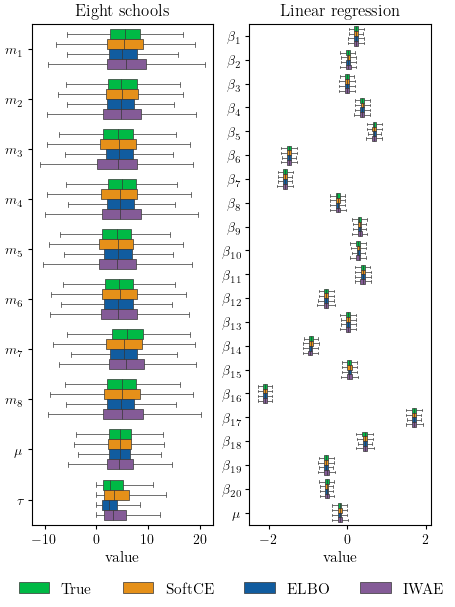

In [4]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(5.15, 6.5)

### Eight schools example ###
samples = task_samples["eight_schools"]
df = samples_to_df(samples)

# Rename parameters to match paper:
rename_dict = {f"theta[{i}]": rf"$m_{{{i+1}}}$" for i in range(8)}
rename_dict["mu"] = r"$\mu$"
rename_dict["tau"] = r"$\tau$"
df["parameter"] = df["parameter"].replace(rename_dict)

kwargs = {
    "x": "value",
    "y": "parameter",
    "hue": "source",
    "showfliers": "",
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.5,
}

sns.boxplot(
    data=df,
    ax=axes[0],
    legend=False,
    **kwargs,
    )

### Linear regression example ###
samples = task_samples["linear_regression"]
df = samples_to_df(samples)

# Rename parameters to match paper:
rename_dict = {f"beta[{i}]": rf"$\beta_{{{i+1}}}$" for i in range(20)}
rename_dict["bias"] = r"$\mu$"
df["parameter"] = df["parameter"].replace(rename_dict)

sns.boxplot(
    data=df,    
    ax=axes[1],
    **kwargs,
    )

for ax in axes:
    ax.set_ylabel(None)

axes[0].set_title("Eight schools")
axes[1].set_title("Linear regression")


ax.legend(bbox_to_anchor=(-0.1, -0.17), loc="lower center", ncol=4)
plt.savefig("plots/single_run_boxplots.pdf")

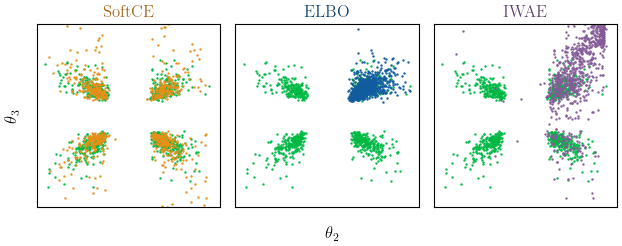

In [5]:
## For SLCP we focus on the posterior marginal showing the four modes
from copy import copy

samples = copy(task_samples["slcp"])
true_samples = samples.pop("True")

fig, axes = plt.subplots(ncols=len(samples))

for ax, (k, v) in zip(axes, samples.items()):
    ax.scatter(
        true_samples.item()["theta"][:, 2],
        true_samples.item()["theta"][:, 3],
        s=0.5,
        label="True",
        color=palette["True"],
        rasterized=True,
        )
    ax.scatter(
        v.item()["theta"][:, 2],
        v.item()["theta"][:, 3],
        label=k,
        s=0.5,
        color=palette[k],
        rasterized=True,
        )
    ax.set_box_aspect(1)
    ax.set_ylim(-1, 1)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    # Make title a little darker so can read easier
    title_color = matplotlib.colors.ColorConverter.to_rgb(palette[k])
    title_color = tuple(0.7*c for c in title_color)
    ax.set_title(k, color=title_color)

fig.supxlabel(r"$\theta_2$",  x= 0.53, y=0.27)
fig.supylabel(r"$\theta_3$", y=0.53)
fig.tight_layout()
fig.savefig("plots/slcp_mass_covering.pdf", dpi=300)
